# Angad Kalra
# SN: 1005134999


# Primary Questions
* Q1: For all active fulltime NYT movie critics, how often do they correctly predict box office hits? 
* Q2: Does movie review sentiment align with whether it was a critic's pick or not?
* Q3: What characterisitcs are common among movies that do really well? Among movies that do poorly? 

# TO DO:
* Go through each Q and complete
* Write Report

# Data Collection

In [1]:
import numpy as np
import pandas as pd
import requests, json, os, sys, time 
import matplotlib.pyplot as plt
from sklearn import linear_model

# Sample data collection code

# API urls & keys
nyt_url = "http://api.nytimes.com/svc/movies/v2"
nyt_apikey = "72aaefb1f009451e986a0e446468f649"

tmdb_url = "https://api.themoviedb.org/3"
tmdb_apikey = "49200255c3dc5d6af15e04656ea5f7c4"

# List of critics
url = nyt_url + "/critics/full-time.json"
critics_res = requests.get(url, params={"api-key": nyt_apikey})
if critics_res.status_code == 200:
    critics_res = json.loads(critics_res.text)
    critics = [x["display_name"] for x in critics_res["results"]]
else:
    print(json.loads(critics_res.text))

# List of genres
genres_url = tmdb_url + "/genre/movie/list"
genres_resp = requests.get(genres_url, params={"api_key": tmdb_apikey})
if genres_resp.status_code == 200:
    genres = json.loads(genres_resp.text)
    genres = [x["name"] for x in genres["genres"]]
else:
    print(json.loads(genres_resp.text))

In [27]:
# Table of movies + financial outcome
url = nyt_url + "/reviews/search.json"
critics_list = []
movie_titles = []
box_office_total = []

def get_bo_total(c, i):
    resp = requests.get(url, params={"api-key": nyt_apikey, "critics-pick": "Y", "reviewer": c,
                                            "offset": int(i*20)})
    
    if resp.status_code == 200:
        resp = json.loads(resp.text)
    else:
        print(json.loads(resp.text))

    results = resp["results"]

    for r in results:
        tmdb_resp = requests.get(tmdb_url + "/search/movie", 
                            params={"api_key": tmdb_apikey, "query": r["display_title"], 
                                    "primary_release_year": int(r["publication_date"][0:4]) })
        
        if tmdb_resp.status_code == 200:
            tmdb_resp = json.loads(tmdb_resp.text)

            if (tmdb_resp["total_results"] > 0):
                mid = tmdb_resp["results"][0]["id"]
                movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), params={"api_key": tmdb_apikey})
                
                if movie_info.status_code == 200:
                    movie_info = json.loads(movie_info.text)

                    if (movie_info["revenue"] > 0):
                        critics_list.append(c)
                        movie_titles.append(movie_info["title"])
                        box_office_total.append(movie_info["revenue"])
        elif tmdb_resp.status_code == 429:
            time.sleep(12)
            
            tmdb_resp = requests.get(tmdb_url + "/search/movie", 
                            params={"api_key": tmdb_apikey, "query": r["display_title"], 
                                    "primary_release_year": int(r["publication_date"][0:4]) })
            
            tmdb_resp = json.loads(tmdb_resp.text)

            if (tmdb_resp["total_results"] > 0):
                mid = tmdb_resp["results"][0]["id"]
                movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), params={"api_key": tmdb_apikey})
                
                if movie_info.status_code == 200:
                    movie_info = json.loads(movie_info.text)

                    if (movie_info["revenue"] > 0):
                        critics_list.append(c)
                        movie_titles.append(movie_info["title"])
                        box_office_total.append(movie_info["revenue"])
            
                
# Get critic pick movies for each critic + info and create dataframe.
for c in critics:
    for i in range(0, 5):
        get_bo_total(c, i)
        
# Create DataFrame from critics, movies, box office revenue. 
df_dict = {"critic": pd.Series(critics_list, dtype=str), "movie_title": pd.Series(movie_titles, dtype=str), 
                        "box_office_total": pd.Series(box_office_total, dtype=np.int64)}
q1_df = pd.DataFrame(df_dict)

In [30]:
# Save data to csv
q1_df.to_csv(path_or_buf="q1_df.csv")

In [31]:
# Analyze Critic BOH Prediction Accuracy

box_office_hit = 60000000

for c in critics:
    c_movies = q1_df.loc[q1_df["critic"] == c]
    num_movies = c_movies.shape[0]
    num_hits = c_movies.loc[c_movies["box_office_total"] >= box_office_hit].shape[0]
    accuracy = num_hits/num_movies
    print("Critic: {0}, # of Picks: {2}, Accuracy: {1}\n".format(c, accuracy, num_movies))

Critic: A. O. Scott, # of Picks: 51, Accuracy: 0.35294117647058826

Critic: Manohla Dargis, # of Picks: 55, Accuracy: 0.34545454545454546

Critic: Stephen Holden, # of Picks: 26, Accuracy: 0.038461538461538464



In [35]:
# Table of movies + review sentiment
from bs4 import BeautifulSoup
from textblob import TextBlob

url = nyt_url + "/reviews/search.json"
movie_titles = []
review_sentiment = []
critic_pick = []

def get_movie_reviews(c, i):
    resp = requests.get(url, params={"api-key": nyt_apikey, "reviewer": c, "offset": int(i*20)})
    
    if resp.status_code == 200:
        resp = json.loads(resp.text)
    else:
        print(json.loads(resp.text))
        
    results = resp["results"]
    
    # For each review by critic, get the review using url
    for r in results:
        review_url = r["link"]["url"]
        resp = requests.get(review_url)
        
        if resp.status_code == 200:
            resp = resp.text
            soup = BeautifulSoup(resp, 'html.parser')
            article = soup.find('section', attrs={'name': "articleBody"})
            paragraphs = article.find_all('p', class_="css-1xl4flh e2kc3sl0")
            
            if (len(paragraphs) > 0):
                review = []
                
                for p in paragraphs:
                    review.append(p.text)
                
                review = "".join(review)
                review = TextBlob(review)
                
                review_sentiment.append(review.sentiment.polarity)
                movie_titles.append(r["display_title"])
                critic_pick.append(r["critics_pick"])

for c in critics:
    for i in range(0,3):
        get_movie_reviews(c,i)
    
# Create DataFrame from movies, review sentiment and critic's pick. 
df_dict = {"movie_title": pd.Series(movie_titles, dtype=str), 
               "review_sentiment": pd.Series(review_sentiment, dtype=np.float16), 
                   "critic_pick": pd.Series(critic_pick, dtype=np.bool)}

q2_df = pd.DataFrame(df_dict)

# Save q2_df to file
q2_df.to_csv(path_or_buf="q2_df.csv")

In [39]:
q2_df.head

<bound method NDFrame.head of                                 movie_title  review_sentiment  critic_pick
0                   The Price of Everything          0.114807        False
1                           Minding the Gap          0.130005         True
2                             Juliet, Naked          0.083435        False
3                         Crazy Rich Asians          0.117737        False
4                                   Custody          0.023285         True
5               Sicario: Day of the Soldado          0.054382        False
6                                Hereditary          0.045715         True
7                                    Adrift          0.086731        False
8                          American Animals          0.058655        False
9                            First Reformed          0.102844         True
10                                Book Club          0.192139        False
11                                 Colossal          0.134033        F

/home/angad/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


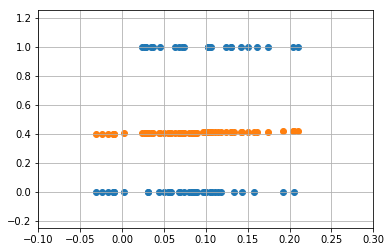

In [40]:
# Analyze Critic Pick vs Sentiment Analysis

x_vals = movie_review_sentiment["review_sentiment"].values.reshape(-1,1)
y_vals = np.array([int(x) for x in movie_review_sentiment["critic_pick"]])

model = linear_model.LogisticRegression().fit(x_vals.reshape(-1,1), y_vals)
y_pred = model.predict_proba(x_vals)

plt.scatter(x_vals, y_vals)
plt.scatter(x_vals, y_pred[:,1]) 
plt.axis([-0.1, 0.30, -0.25, 1.25])
plt.grid(True)
plt.show()

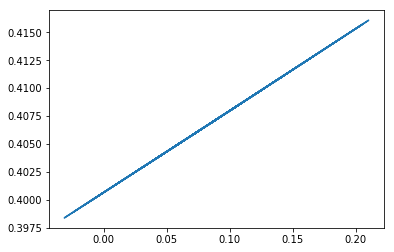

In [41]:
plt.plot(x_vals, y_pred[:,1])
plt.show()

In [29]:
# Top 100 revenue movie characteristics

top100_url = tmdb_url + "/discover/movie"
top100_movies = []

def handle_resp(resp):
    resp = json.loads(resp.text)
    results = resp["results"]

    for r in results:
        mid = r["id"]
        movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), 
                                params={"api_key": tmdb_apikey})

        if movie_info.status_code == 200:
            movie_info = json.loads(movie_info.text)
            top100_movies.append({"budget": movie_info["budget"], "genres": movie_info["genres"], 
                                  "release_date": movie_info["release_date"],
                                    "revenue": movie_info["revenue"], "title": movie_info["title"]} )
        else:
            print("movie request with id {} didn't work".format(mid))
            continue

for i in range(1,10):
    resp = requests.get(top100_url, params={"api_key": tmdb_apikey, "sort_by": "revenue.desc", "page": i,
                                           "primary_release_date.gte": "2010-01-01", 
                                            "primary_release_data.lte": "2017-01-01"})
    if (resp.status_code == 200):
        handle_resp(resp) 
    elif resp.status_code == 429:
        time.sleep(13)
        handle_resp(resp)
    else:
        print(json.loads(resp.text))


movie request with id 328111 didn't work
movie request with id 209112 didn't work
movie request with id 141052 didn't work


In [90]:
# Create top 100 movies DataFrame
top100_cols = ["title", "budget", "release_season"]
top100_cols.extend(genres)
top100_cols.append("revenue")

df_dict = {}
for key in top100_cols:
    df_dict[key] = []

for g in genres:
    df_dict[g] = [0]*len(top100_movies)
    
for ind, movie in enumerate(top100_movies):
    df_dict["budget"].append(movie["budget"])
    df_dict["title"].append(movie["title"])
    df_dict["revenue"].append(movie["revenue"])
    
    movie_genres = [x["name"] for x in movie["genres"]]
    
    for g in movie_genres:
        df_dict[g][ind] = 1
        
    release_month = int(movie["release_date"].split("-")[1])
    
    if release_month in [1, 2, 12]:
        df_dict["release_season"] = "Winter"
    elif release_month in [3, 4, 5]:
        df_dict["release_season"] = "Spring"
    elif release_month in [6, 7, 8]:
        df_dict["release_season"] = "Summer"
    else:
        df_dict["release_season"] = "Fall"

top100_df = pd.DataFrame.from_dict(df_dict)

# Save top100_df to csv
top100_df.to_csv(path_or_buf="top100_df.csv")

In [100]:
# Bottom 100 revenue movie characteristics

bottom100_url = tmdb_url + "/discover/movie"
bottom100_movies = []

# buffer between top100 movies code running
time.sleep(11)

def handle_resp(resp):
    resp = json.loads(resp.text)
    results = resp["results"]

    for r in results:
        mid = r["id"]
        movie_info = requests.get(tmdb_url + "/movie/{}".format(mid), 
                                params={"api_key": tmdb_apikey})

        if movie_info.status_code == 200:
            movie_info = json.loads(movie_info.text)
            bottom100_movies.append({"budget": movie_info["budget"], "genres": movie_info["genres"], 
                                  "release_date": movie_info["release_date"],
                                    "revenue": movie_info["revenue"], "title": movie_info["title"]} )
        else:
            print("movie request with id {} didn't work".format(mid))
            continue 

for i in range(10,12):
    resp = requests.get(bottom100_url, params={"api_key": tmdb_apikey, "sort_by": "revenue.desc", "page": i,
                                           "primary_release_date.gte": "2010-01-01", 
                                            "primary_release_data.lte": "2017-01-01"})
    if (resp.status_code == 200):
        handle_resp(resp)
    elif resp.status_code == 429:
        time.sleep(13)
        handle_resp(resp)
    else:
        json.loads(resp.text)



In [101]:
# Create bottom 100 movies DataFrame
bottom100_cols = ["title", "budget", "release_season"]
bottom100_cols.extend(genres)
bottom100_cols.append("revenue")

df_dict = {}
for key in bottom100_cols:
    df_dict[key] = []

for g in genres:
    df_dict[g] = [0]*len(bottom100_movies)
    
for ind, movie in enumerate(bottom100_movies):
    df_dict["budget"].append(movie["budget"])
    df_dict["title"].append(movie["title"])
    df_dict["revenue"].append(movie["revenue"])
    
    movie_genres = [x["name"] for x in movie["genres"]]
    for g in movie_genres:
        df_dict[g][ind] = 1
        
    release_month = int(movie["release_date"].split("-")[1])
    
    if release_month in [1, 2, 12]:
        df_dict["release_season"] = "Winter"
    elif release_month in [3, 4, 5]:
        df_dict["release_season"] = "Spring"
    elif release_month in [6, 7, 8]:
        df_dict["release_season"] = "Summer"
    else:
        df_dict["release_season"] = "Fall"

bottom100_df = pd.DataFrame.from_dict(df_dict)

# Save data to file
bottom100_df.to_csv(path_or_buf="bottom100_df.csv")

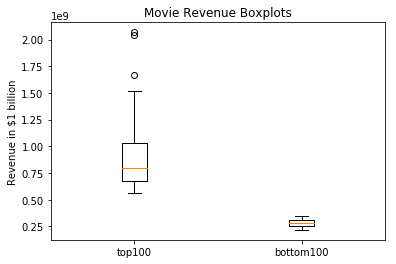

In [102]:
# Revenue boxplots

top100_rev = top100_df["revenue"].values
bot100_rev = bottom100_df["revenue"].values

plt.boxplot([top100_rev, bot100_rev], labels=["top100", "bottom100"])
plt.title("Movie Revenue Boxplots")
plt.ylabel("Revenue in $1 billion")
plt.show()

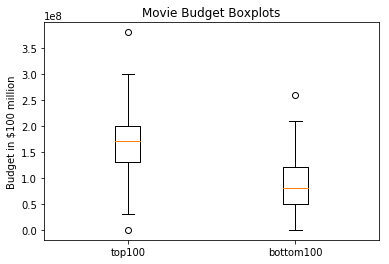

In [103]:
# Analyze top100 and bottom100 datasets

# Budget boxplots
top100_budget = top100_df["budget"].values
bot100_budget = bottom100_df["budget"].values

plt.boxplot([top100_budget, bot100_budget], labels=["top100", "bottom100"])
plt.title("Movie Budget Boxplots")
plt.ylabel("Budget in $100 million")
plt.show()

In [104]:
# Release Season Histogram
top100_relseason = top100_df["release_season"].value_counts()
bott100_relseason_counts = bottom100_df["release_season"].value_counts()

In [105]:
print (top100_relseason_counts)
print (bott100_relseason_counts)

Summer    97
Name: release_season, dtype: int64
Summer    100
Name: release_season, dtype: int64


In [ ]:
# Most Common Genres
